參考 link :https://www.kaggle.com/code/ryotayoshinobu/foursquare-lightgbm-baseline
This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c foursquare-location-matching
! unzip foursquare-location-matching.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 154M/159M [00:00<00:00, 187MB/s]
100% 159M/159M [00:00<00:00, 198MB/s]
Archive:  foursquare-location-matching.zip
  inflating: pairs.csv               
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib

# 宣告一個專門放參數的 class
class CFG: # configuration
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

# %cd /content/drive/MyDrive/kaggle/foursquare-location-matching/{CFG.expID}

In [8]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
test[CFG.target] = "TEST"

train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


# Devide Train Data into about 600K×2

In [9]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [10]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,0.0
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0.0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0.0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,0.0


# 資料代入 / 插補 / 填補 Data Imputation

In [11]:
from sklearn.neighbors import KNeighborsRegressor
# 把每一個地點都加上 另外一個最近地點的資訊
def add_neighbor_features(df):
    dfs = []
    # 需要 id 不然不沒辦法做後方 matches 的 set、沒辦法算分數
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
#     columns = ['name', 'address', 'city', 'state',
#             'zip', 'country', 'url', 'phone', 'categories']
#     for c in columns:
#         df[c] = df[c].astype(str).str.lower()
            
    # 把相同國家的 row 放進同一個 dataframe 裡面
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        # n_neighbors 表示要參考附近的幾筆資料才決定屬於哪一群
#         print(len(country_df))
        k = min(len(country_df), CFG.n_neighbors)
        knn = KNeighborsRegressor(n_neighbors=k, 
                                  metric='haversine', n_jobs=-1)
        
        # 使用相同的"國家群"進行訓練
        # 同個國家的資料當成一群進行訓練
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        
        # 得出分群後的資料，回傳每個點與最近的幾個點的距離與 indices
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
#         print("dists, nears\n",dists,nears)
        # 將 n_neighbors 各點的資料呈現在 country_df 上
        targets = country_df[CFG.target].values
        for i in range(k):
            country_df[f"d_near_{i}"] = dists[:, i]
#             print("d_near_",i,dists[:, i])
            country_df[f"near_target_{i}"] = targets[nears[:, i]]
            for c in columns:
                country_df[f"near_{c}_{i}"] = country_df[c].values[nears[:, i]]
        # 若整個國家的資料點數量小於預設所需的 k ，則將多出的部分填補為 nan
        for i in range(k, CFG.n_neighbors):
            country_df[f"d_near_{i}"] = np.nan
            country_df[f"near_target_{i}"] = np.nan
            for c in columns:
                country_df[f"near_{c}_{i}"] = np.nan

        dfs.append(country_df)
#         break
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [12]:
# original_train = train

In [13]:
# add_neighbor_features(original_train)

In [14]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,0.0
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0.0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0.0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,0.0


In [15]:
# 擴充 train 的 n_neighbors 的資料
train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_9,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_bb40eb6b8aa6c9,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas


In [16]:
# train

# Analysis: Threshold


## 順位法
以距離順位(k)為基準分析趨勢：
1. 判斷多近「還有機會」是同個 POI
    * 後面的結果會覆蓋前面的結果
2. (?) 判斷多近「就會」是同個 POI
    * p.s.「多近」是以距離順位（第幾近）來判斷，而非是以絕對距離來看。
3. 判斷第一個 match 在哪 (0)

In [17]:
for i in range(CFG.n_neighbors):
  print(i)

0
1
2
3
4
5
6
7
8
9


In [18]:
train.loc[:,"target"] = 0
# 1.
# [x] 判斷前幾個相同分群的經緯度是相同 POI
## 有可能第 2 個不同但第 4 個同，而 4 覆蓋掉 2，因此不代表前四個都是相同
## [?] 但此處的問題為，把經緯度分群當成唯一影響，所以才直接照順序決定 target(同一個 POI 的情況下，最大的 i)
for i in range(CFG.n_neighbors):
#     print(train[CFG.target]==train[f"near_target_{i}"])
    train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i

# 2. (after 1.)
# # wtf is that? >by Howard
# train.loc[:,"not done"] = True
# for i in train.iterrows():
#     print(type(i))
#     train.loc[train[CFG.target]!=train[f"near_target_{i}"], "not done"] = False
#     train.loc[(train[CFG.target]==train[f"near_target_{i}"]) & (train["not done"]), "target"] = i

# 3.
# for i in range(CFG.n_neighbors-1, -1, -1):
# #     print(train[CFG.target]==train[f"near_target_{i}"])
#     train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i
    
    
# list(train.columns)
train['target'].tail(10)

569396    1
569397    1
569398    1
569399    1
569400    2
569401    3
569402    0
569403    0
569404    0
569405    0
Name: target, dtype: int64

In [19]:
train['target'].max()

9

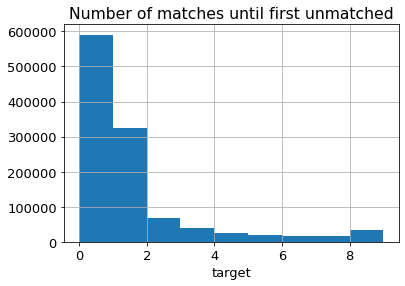

In [20]:
plt.hist(train["target"], bins=sorted(train["target"].unique()))
plt.grid()
plt.xlabel("target")
plt.title('Number of matches until first unmatched')
# plt.title('Number of the last match')
plt.show()

## 絕對距離法
直接以距離的值來判定

In [21]:
# for index, row in train.iterrows():
# #     print("row", row)
# #     print("row['target']", row["target"])
# #     print("row[row['target']]", row[row["target"]])
# #     if index == 3:
# #         break
#     ## wtf is that? >by Howard
#     row["max_dist"] = row[row["target"]]


# for i in range(CFG.n_neighbors):
#     train.loc[train[CFG.target]!=train[f"near_target_{i}"], "done"] = True
#     ## Assign i to all elements in train['target'] where train['POI']==train[near_target_i]
#     train.loc[(train[CFG.target]==train[f"near_target_{i}"]) & (train["done"] != True), "target"] = train[f"d_near_{i}"]
    
# list(train.columns)
# train['target'].head(10)

# Validation

## Two-way Hash
用雜湊表來將正確答案產出

In [22]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics

## 將input dataframe 轉成 dict，再拿出 id 與 poi 用 dict 回傳
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

## 將input dataframe 轉成 dict，再以 poi 為 index、取出"屬於此 poi"的 id set 用 dict 回傳
def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

## 比對
利用 KNN 的結果做出預測，再與正確答案做比對

In [23]:
## 已有 matches
def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        # 找出與該 id 相同 poi 之所有 id
        targets = poi2ids[id2poi[id_str]]
        # 整理 matches 格式 (根據 train + knn 所得) (以空格分割)
        preds = set(matches.split())
        # 比分數
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

In [24]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9,target
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,1
1,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,borda xica,c/ cap del carrer,la massana,ordino,nan,ad,nan,376837190,restaurants,1
2,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,burger king near szgm,ad,ad,nan,nan,ad,nan,nan,american restaurants,6
3,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,1
4,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,ahotels piolets park & spa,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,871787,"hotels, resorts, buffets",0


In [25]:
scores = []
# 用 poi 去 check 每一個 n_neighors 的 poi，把 poi 相同的 id 加在 matches 這個新增的 column
# 此外這裡每次多考慮一個 neighbor，就多算一次分數
train["matches"] = ""
for i in tqdm(range(CFG.n_neighbors)):
    # 一次是看某一個i，直的一整大排去賦值
    idx = train[CFG.target]==train[f"near_target_{i}"]
    # idx 裡面是 true 才會 access 到那一個 row
    train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]
    # 算分數囉～
    scores.append(get_score(train))
# 把紀錄刪光光
train["matches"] = None

  0%|          | 0/10 [00:00<?, ?it/s]

[0.6484506075339209, 0.8020225149439327, 0.8325236657705021, 0.8501963189455756, 0.8612881015205666, 0.8695578186566711, 0.8760523984244069, 0.8814800634456692, 0.8860158384529265, 0.8898691517949306]


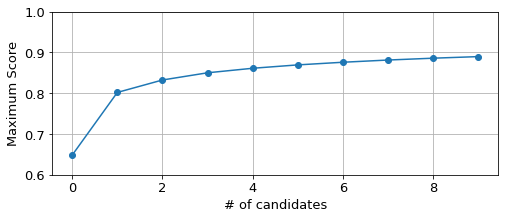

In [26]:
# 會發現每多考慮一個 candidate 分數就可以提高
plt.subplots(figsize=(8, 3), facecolor="white")
print(scores)
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [27]:
# 清記憶體垃圾
# del train
gc.collect()

2258

In [28]:
train.drop('matches', axis=1)

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9,target
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,1
1,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,borda xica,c/ cap del carrer,la massana,ordino,nan,ad,nan,376837190,restaurants,1
2,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,burger king near szgm,ad,ad,nan,nan,ad,nan,nan,american restaurants,6
3,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,1
4,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,ahotels piolets park & spa,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,871787,"hotels, resorts, buffets",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569401,E_fae582b1324e86,devil's pool,-17.923867,25.854207,livingstone island,livingstone,nan,nan,zm,nan,...,lazy men's,nan,nan,nan,nan,zm,nan,nan,nan,3
569402,E_07ec12a516df45,apple avondale,-17.802884,31.038358,nan,nan,nan,nan,zw,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
569403,E_1827a3004c29ef,pelos,40.473167,-3.687866,nan,nan,nan,nan,zw,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
569404,E_4c57a92c895eef,victoria falls national park,-17.926155,25.842538,victoria falls,nan,nan,nan,zw,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Feature Engineering

In [29]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 5.0 MB/s 
     |████████████████████████████████| 1.8 MB 52.8 MB/s 
     |████████████████████████████████| 103 kB 49.1 MB/s 


In [30]:
%load_ext Cython

In [31]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [32]:
# 利用 Levenshtein、difflib 算出兩字串的各種 features 相異程度數值，並把數值加入到 features 內
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for i in tqdm(range(CFG.n_neighbors)):
        for c in columns:
            geshs = []
            levens = []
            jaros = []
            lcss = []
            str_enter_count = 0
            for str1, str2 in df[[f"near_{c}_0", f"near_{c}_{i}"]].values.astype(str):
                str_enter_count += str_enter_count
                if str_enter_count >= 2:
                    print("bigger than 2","i = ", i,"c =", c)
                # 檢查是否為 NaN
                if str1==str1 and str2==str2:
                    geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                    levens.append(Levenshtein.distance(str1, str2))
                    jaros.append(Levenshtein.jaro_winkler(str1, str2))
                    lcss.append(LCS(str(str1), str(str2)))
                else:
                    geshs.append(-1)
                    levens.append(-1)
                    jaros.append(-1)
            df[f"near_{c}_{i}_gesh"] = geshs
            df[f"near_{c}_{i}_leven"] = levens
            df[f"near_{c}_{i}_jaro"] = jaros
            df[f"near_{c}_{i}_lcs"] = lcss
            # 如果是 namen, address, city, state, url, categories 的情況下，再多加一個平均的 feature
            if not c in ['country', "phone", "zip"]:
                df[f"near_{c}_{i}_len"] = df[f"near_{c}_{i}"].astype(str).map(len)
                df[f"near_{c}_{i}_nleven"] = df[f"near_{c}_{i}_leven"] / df[[f"near_{c}_{i}_len", f"near_{c}_0_len"]].max(axis=1)
                df[f"near_{c}_{i}_nlcsi"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_{i}_len"]
                df[f"near_{c}_{i}_nlcs0"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_0_len"]
    return df

# muilty processing
def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [33]:
len(train)

1138812

In [34]:
training_data = train.sample(frac=0.2, random_state=25)

In [35]:
len(training_data)

227762

##stop plz

In [36]:
train = add_distance_features(training_data)
# test = add_distance_features(test)

0it [00:00, ?it/s]

# Delete Unusing Columns for avoiding OOM (out of memory)

In [37]:
# 在上面的 block 我們已經把新的 feature 加入到 dataframe 內了，這裡 features 的目的就是為了移掉其他不重要的 features
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']
for i in tqdm(range(CFG.n_neighbors)):
    features.append(f"d_near_{i}")
    for c in columns:        
        features += [f"near_{c}_{i}_gesh", f"near_{c}_{i}_jaro", f"near_{c}_{i}_lcs"]
        if c in ['country', "phone", "zip"]:
            features += [f"near_{c}_{i}_leven"]
        else:
            features += [f"near_{c}_{i}_len", f"near_{c}_{i}_nleven", f"near_{c}_{i}_nlcsi", f"near_{c}_{i}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

# print(features)

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
# 把剛剛所有資訊放進 train 與 test
train = train[features + [CFG.target, "target", "id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]
test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

# train.info()

**訓練與測試資料的格式???**
- X 包含 
    - CFT 的資訊
    - n_neighber = 10, 的所有資訊
    - n_neighber 跟 CFT.target 相關的所有字串配對分數
- y 包含
    - 相同 POI 之中，最大的 neighber

# Split Folds

In [39]:
# kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
# shuffle 應該要是 false? 這樣每個點都才會被平均的當成訓練資料，不會漏掉 > Howard
kf = StratifiedKFold(n_splits=CFG.n_splits) 
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    print(i, len(trn_idx), len(val_idx))
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

0 151841 75921
1 151841 75921
2 151842 75920


# Model Learning
使用 lightGBM 演算法

In [40]:
import lightgbm as lgbm

# n-class 表示分類結果有哪些, n_split 表示 k-fold 做幾次
def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), n_class), dtype=np.float64)
    
    # 不同的 split number 就存不同的模型 k-fold cross validation> Howard
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        # 把剛剛分完群的拿出來
        trn_idx = folds!=i
        val_idx = folds==i
        # 拿出不同 dataframe
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        # 不存在就訓練
        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='logloss',  
        #       verbose=-1)
                verbose=50)
        # 存在就 load 出來, 等等跑分數
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
        # X_valid 如果是100 筆數據, 且 5個 class,那 pred 的 dimension = (100, 5)
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = f'lgbm_fold{i}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models
# 直接用 model.predict_proba 跑結果
def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

## 開始訓練資料

In [41]:
train["target"].max()

9

In [42]:
params = {
    'objective': "logloss",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                       params=params, n_class=int(train["target"].max()+ 1),
                       N_SPLITS=CFG.n_splits, folds=train["fold"].values)


  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's multi_logloss: 0.506108	valid_0's multi_logloss: 0.506108
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.505563	valid_0's multi_logloss: 0.505563

== fold 1 ==
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's multi_logloss: 0.603863	valid_0's multi_logloss: 0.603863
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.599688	valid_0's multi_logloss: 0.599688

== fold 2 ==
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's multi_logloss: 0.447612	valid_0's multi_logloss: 0.447612
[100]	valid_0's multi_logloss: 0.441117	valid_0's multi_logloss: 0.441117
Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.440939	valid_0's multi_logloss: 0.440939

CV-accuracy: 0.8269070345360507


In [43]:
# 根據不同的分組，拿出不同的 model
models = [joblib.load(f'lgbm_fold{i}.pkl') for i in range(CFG.n_splits)]
# 這裡直接測試test data 並回傳 k-fold 不同模型的預測結果平均
pred = inference_lgbm(models, test[features])

# Check CV

In [44]:
# 每個 id 的周遭 10 個 ids 為誰 (dimension = i * 10)
near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
# 掃過全部的 train row ，得出其中的 id
# ps 為所有 id 的預測結果
# ids 周遭 10 個 id 為誰
for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
    # 找出最大的那個 class 的值，代表預測的 target 是多少
    idx = np.argmax(ps)
    # 如果 idx 不是自己，且也不是 Nan, 就 append 自己 跟 idx 進去
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    # 否則只 append 自己
    else:
        matches.append(id)
train["matches"] = matches
print(f"CV: {get_score(train):.6f}")

0it [00:00, ?it/s]

CV: 0.795323


In [45]:
# test one more time
near_ids = test[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(test["id"], pred, near_ids)):
    idx = np.argmax(ps)
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    else:
        matches.append(id)
test["matches"] = matches

0it [00:00, ?it/s]

# Check Feature Importances

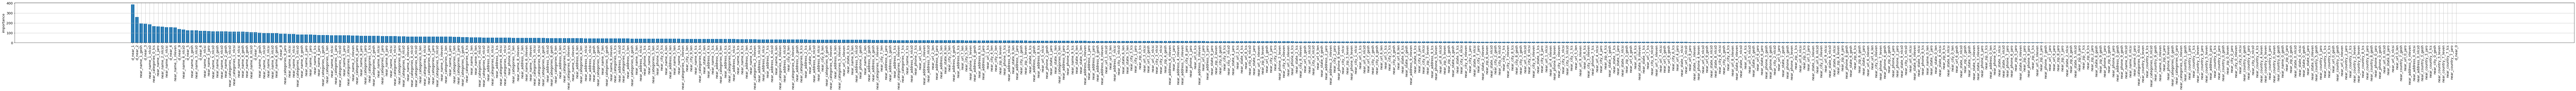

In [46]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [47]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue
        
        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

#train = postprocess(train)
test = postprocess(test)
# print(f"CV: {get_score(train):.6f}")

  0%|          | 0/5 [00:00<?, ?it/s]

In [55]:
test

,d_near_0,near_name_0_gesh,near_name_0_jaro,near_name_0_lcs,near_name_0_len,near_name_0_nleven,near_name_0_nlcsi,near_name_0_nlcs0,near_address_0_gesh,near_address_0_jaro,...,near_id_1,near_id_2,near_id_3,near_id_4,near_id_5,near_id_6,near_id_7,near_id_8,near_id_9,matches
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,E_0283d9f61e569d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E_001b6bad66eb98
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,E_001b6bad66eb98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E_0283d9f61e569d
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E_00001118ad0191
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E_00002f98667edf
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E_000020eb6fed40


# Submit

In [ ]:
ssub = pd.read_csv("submission.csv")
ssub = ssub.drop(columns="matches")
ssub = ssub.merge(test[["id", "matches"]], on="id")
ssub.to_csv("submission.csv", index=False)

ssub.head()